In [5]:
import os
import pickle
from omegaconf import DictConfig, OmegaConf
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [6]:
class DataGenerate:
    def __init__(self, config: DictConfig, if_save: bool) -> None:
        """
        初始化 DataGenerate 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        
        base_config = config.base
        data_gen_config = config.data_generation.load_data

        self.N = base_config.N
        self.T = base_config.T
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test
        self.node_mean = data_gen_config.node_mean
        self.node_var = data_gen_config.node_var
        self.node_iid_var = data_gen_config.node_iid_var
        self.node_theta = data_gen_config.node_theta

        # 初始化其他属性
        self.means_loads = self._generate_means()  # 生成节点的平均负载
        self.load_iid, self.mean_iid = self._generate_iid_data()  # 生成iid数据
        self.load_ar1, self.mean_ar1 = self._generate_ar1_data()  # 生成ar1数据

        # 保存数据并打印信息
        self._save_data() if if_save else None
        self.print_data_generate_info()
        self.plot_original_means()

    def _generate_means(self) -> np.ndarray:
        """
        生成节点的平均负载数据。
        
        :return: 包含节点平均负载的 numpy 数组
        """
        return np.random.normal(self.node_mean, self.node_var, size=(self.N,))

    def _generate_iid_data(self) -> tuple[np.ndarray, np.ndarray]:
        """
        生成 IID 数据。

        :return: 生成的 IID 数据和每个节点的均值
        """
        loads = np.array([
            np.random.normal(
                loc=self.means_loads[i],
                scale=self.node_iid_var,
                size=self.T_train_val + self.T_test
            ) for i in range(self.N)
        ])
        return loads, np.mean(loads, axis=1)

    def _generate_ar1_data(self) -> tuple[np.ndarray, np.ndarray]:
        """
        生成 AR(1) 数据。

        :return: 生成的 AR(1) 数据和每个节点的均值
        """
        loads = np.zeros((self.N, self.T_train_val + self.T_test))

        def generate_ar1(mean_node: float) -> np.ndarray:
            ar1 = torch.zeros(self.T_train_val + self.T_test)
            ar1[0] = mean_node
            for t in range(1, self.T_train_val + self.T_test):
                ar1[t] = (
                        self.node_theta * ar1[t - 1] +
                        (1 - self.node_theta) * mean_node +
                        np.random.normal(0, 1)
                )
            return ar1.numpy()

        for i in range(self.N):
            loads[i] = generate_ar1(self.means_loads[i])

        return loads, np.mean(loads, axis=1)

    def _save_data(self) -> None:
        """
        将生成的数据保存为 CSV 文件。
        """
        pd.DataFrame(self.load_iid).to_csv('Data/load_iid_data.csv', index=False)
        pd.DataFrame(self.load_ar1).to_csv('Data/load_ar1_data.csv', index=False)

    def print_data_generate_info(self) -> None:
        """
        打印生成的数据的基本信息。
        """
        print('-----------------Data Generate Info-----------------')
        print('means_loads.shape:', self.means_loads.shape)
        print('load_iid.shape:', self.load_iid.shape)
        print('mean_iid.shape:', self.mean_iid.shape)
        print('load_ar1.shape:', self.load_ar1.shape)
        print('mean_ar1.shape:', self.mean_ar1.shape)

    def plot_original_means(self) -> None:
        """
        绘制生成的节点平均负载。
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.means_loads, marker='o', linestyle='-', color='b', label='means_load')
        plt.title('Original Random Means of Nodes of Load')
        plt.xlabel('Node')
        plt.ylabel('Mean Load')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [9]:
class TrainValidManage:
    def __init__(self, config: DictConfig, data_type: bool) -> None:
        """
        初始化 TrainValidManage 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        base_config = config.base
        exp4_config = config.exp4

        # self.data_type = base_config.data_type  # 从 base_config 提取 data_type
        self.data_type = data_type
        self.device = exp4_config.device  # 从 exp4_config 提取设备信息
        self.batch_size = exp4_config.batch_size
        self.num_workers = exp4_config.num_workers
        self.N = base_config.N
        self.T = base_config.T
        self.T_train = base_config.T_train
        self.T_val = base_config.T_val
        self.train_ratio = base_config.train_ratio
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test
        self.seq_length = exp4_config.seq_length

        # 加载数据
        self.load_iid = pd.read_csv('Data/load_iid_data.csv').values
        self.load_ar1 = pd.read_csv('Data/load_ar1_data.csv').values

        # 根据数据类型选择数据
        if self.data_type == 'iid':
            self.data_np = self.load_iid
        elif self.data_type == 'ar1':
            self.data_np = self.load_ar1

        # 将数据转换为 PyTorch 张量
        self.data_tensor = torch.tensor(self.data_np, device=self.device, dtype=torch.float32)

        # 划分np.array的训练集、验证集和测试集
        self.train_val_data_np = self.data_np[:, :self.T_train_val]
        self.train_data_np = self.data_np[:, :self.T_train]
        self.val_data_np = self.data_np[:, self.T_train:self.T_train_val]
        self.test_data_np = self.data_np[:, self.T_train_val:]

        # 储存tensor的训练集、验证集和测试集
        self.train_val_data_tensor = torch.tensor(self.train_val_data_np, device=self.device, dtype=torch.float32)
        self.train_data_tensor = torch.tensor(self.train_data_np, device=self.device, dtype=torch.float32)
        self.val_data_tensor = torch.tensor(self.val_data_np, device=self.device, dtype=torch.float32)
        self.test_data_tensor = torch.tensor(self.test_data_np, device=self.device, dtype=torch.float32)

        # # 创建训练集和验证集的序列数据，用于训练和验证
        # self.train_val_x, self.train_val_y = self._create_sequences(self.train_val_data_np)
        # self.train_x, self.train_y = self._create_sequences(self.train_data_np)
        # self.val_x, self.val_y = self._create_sequences(self.val_data_np)
        # 
        # # 创建训练集和验证集的序列数据，用于训练和验证
        # self.train_val_x, self.train_val_y = self._create_sequences(self.train_val_data_np, self.test_data_np)
        # self.train_x, self.train_y = self._create_sequences(self.train_data_np, self.val_data_np)
        # self.val_x, self.val_y = self._create_sequences(self.val_data_np, self.test_data_np)

        # 创建训练集、验证集、训练验证集的序列数据
        self.train_val_x, self.train_val_y = self._create_sequences(self.data_np, 'train_val')
        self.train_x, self.train_y = self._create_sequences(self.data_np, 'train')
        self.val_x, self.val_y = self._create_sequences(self.data_np, 'val')

        # 创建TensorDataset，用于创建DataLoader
        self.train_val_dataset = TensorDataset(self.train_val_x, self.train_val_y)
        self.train_dataset = TensorDataset(self.train_x, self.train_y)
        self.val_dataset = TensorDataset(self.val_x, self.val_y)
        
        # 创建数据加载器
        self.train_val_dataloader = DataLoader(self.train_val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        # 打印信息
        self.print_train_valid_info()
        self.print_dataloader_info(self.train_val_dataloader, title='Train and Valid')
        self.print_dataloader_info(self.train_dataloader, title='Train')
        self.print_dataloader_info(self.val_dataloader, title='Valid')

        # 创建GNN的边索引
        self.edge_index_tensor = torch.tensor(
            np.array([(i, j) for i in range(self.N) for j in range(self.N)]).T,
            dtype=torch.long)  # 默认全连接图

    # def _create_sequences(self, data: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
    #     """
    #     根据数据创建序列数据。
    #
    #     :param data: 输入的numpy数组数据
    #     :return: 生成的输入序列张量和目标序列张量
    #     """
    #     x, y = [], []
    #     for i in range(data.shape[1] - self.seq_length):
    #         x.append(data[:, i: i + self.seq_length].T)
    #         y.append(data[:, i + self.seq_length])
    #     return torch.tensor(np.array(x)), torch.tensor(np.array(y))

    # def _create_sequences(self, data: np.ndarray, next_data: np.ndarray = None) -> tuple[torch.Tensor, torch.Tensor]:
    #     """
    #     根据数据创建序列数据。如果指定了 next_data，则最后一个 y 值来自 next_data 的第一个值。
    # 
    #     :param data: 输入的numpy数组数据
    #     :param next_data: 下一个数据集，用于提供最后一个 y 的目标值
    #     :return: 生成的输入序列张量和目标序列张量
    #     """
    #     x, y = [], []
    #     for i in range(data.shape[1] - self.seq_length):
    #         x.append(data[:, i: i + self.seq_length].T)
    #         y.append(data[:, i + self.seq_length])
    # 
    #     # 如果有 next_data，则将最后一个 y 设置为 next_data 的第一个值
    #     if next_data is not None:
    #         x.append(data[:, -self.seq_length:].T)  # 最后一个输入序列
    #         y.append(next_data[:, 0])  # 下一个数据集的第一个值
    # 
    #     return torch.tensor(np.array(x)), torch.tensor(np.array(y))
    
    def _create_sequences(self, data: np.ndarray, split_type: str) -> tuple[torch.Tensor, torch.Tensor]:
        """
        根据数据创建序列数据。
        
        :param data: 输入的numpy数组数据
        :param split_type: 数据的切分类型（'train', 'val', 'train_val'）
        :return: 生成的输入序列张量和目标序列张量
        """
        x, y = [], []

        if split_type == 'train':
            # 训练集，从1到8000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'val':
            # 验证集，从8001到10000 (用7981-8000预测8001)
            for i in range(self.T_train, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'train_val':
            # 训练验证集，从1到10000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        return torch.tensor(np.array(x)), torch.tensor(np.array(y))
    
    def print_train_valid_info(self) -> None:
        """
        打印训练和验证数据的信息。
        """
        print('-----------------Train and Valid Data Info-----------------')
        print('load_iid.shape:', self.load_iid.shape)
        print('load_ar1.shape:', self.load_ar1.shape)
        print('data_type:', self.data_type)
        print('data_np.shape:', self.data_np.shape)
        print('data_tensor.shape:', self.data_tensor.shape)
        print('T:', self.T)
        print('T_train:', self.T_train)
        print('T_val:', self.T_val)
        print('train_ratio:', self.train_ratio)
        print('T_train_val:', self.T_train_val)
        print('T_test:', self.T_test)
        print('train_val_data_np.shape:', self.train_val_data_np.shape)
        print('train_data_np.shape:', self.train_data_np.shape)
        print('val_data_np.shape:', self.val_data_np.shape)
        print('test_data_np.shape:', self.test_data_np.shape)
        print('train_val_data_tensor.shape:', self.train_val_data_tensor.shape)
        print('train_data_tensor.shape:', self.train_data_tensor.shape)
        print('val_data_tensor.shape:', self.val_data_tensor.shape)
        print('test_data_tensor.shape:', self.test_data_tensor.shape)
        print('train_val_x.shape:', self.train_val_x.shape)
        print('train_val_y.shape:', self.train_val_y.shape)
        print('train_x.shape:', self.train_x.shape)
        print('train_y.shape:', self.train_y.shape)
        print('val_x.shape:', self.val_x.shape)
        print('val_y.shape:', self.val_y.shape)

    def print_dataloader_info(self, dataloader: DataLoader, title: str) -> None:
        """
        打印 DataLoader 的信息。
    
        :param dataloader: DataLoader 对象
        :param title: 信息标题
        """
        print(f'{"-"*10} {title} Dataloader Info {"-"*10}')
    
        # 打印头部行，展示 min/max 和 shape 信息
        print(f'{"Batch":<10} {"x.min":<8} {"x.max":<8} {"y.min":<8} {"y.max":<8} {"x.shape:torch.Size":<18} {"y.shape:torch.Size":<18}')
    
        # 打印每个批次的信息
        for i, (x, y) in enumerate(dataloader):
            if i % 30 == 0 or i == len(dataloader) - 1:
                x_shape_str = str(list(x.shape))  # 使用 list 来缩短 shape 显示
                y_shape_str = str(list(y.shape))
    
                print(f'{i + 1:>5}/{len(dataloader):<5} '
                      f'{x.min():<8.4f} {x.max():<8.4f} '
                      f'{y.min():<8.4f} {y.max():<8.4f} '
                      f'{x_shape_str:<18} {y_shape_str:<18}')



    def plot_range_data(self, data: np.ndarray, start: int = None, end: int = None, title: str = 'Load Data') -> None:
        """
        绘制指定范围内的数据。

        :param data: 输入数据
        :param start: 开始时间步，默认为0
        :param end: 结束时间步，默认为数据结束
        :param title: 图像标题
        """
        start = 0 if start is None else start
        end = data.shape[1] if end is None else end

        time_steps = np.arange(start, end)
        plt.figure(figsize=(12, 6))
        for i in range(data.shape[0]):
            plt.plot(time_steps, data[i, start:end], label=f'Node {i}')
        plt.title(f'{title} - Nodes {0}-{data.shape[0]}')
        plt.xlabel('Time')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  num_workers: 24
  num_epochs: 100
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.001
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMConfig:
    learning_rate: 0.001
    hidden_size: 128
    num_layers: 4
    dropout_prob: 0.2
    weight_decay: 0.0001
  GNNConfig:
    learning_rate: 0.001
    hidden_size: 128

-----------------Data Generate Info-----------------
means_loads.shape: (10,)
load_iid.shape: (10, 11000)
mean_iid.shape: (10,)
load_ar1.shape: (10, 11000)
mean_ar1.shape: (10,)


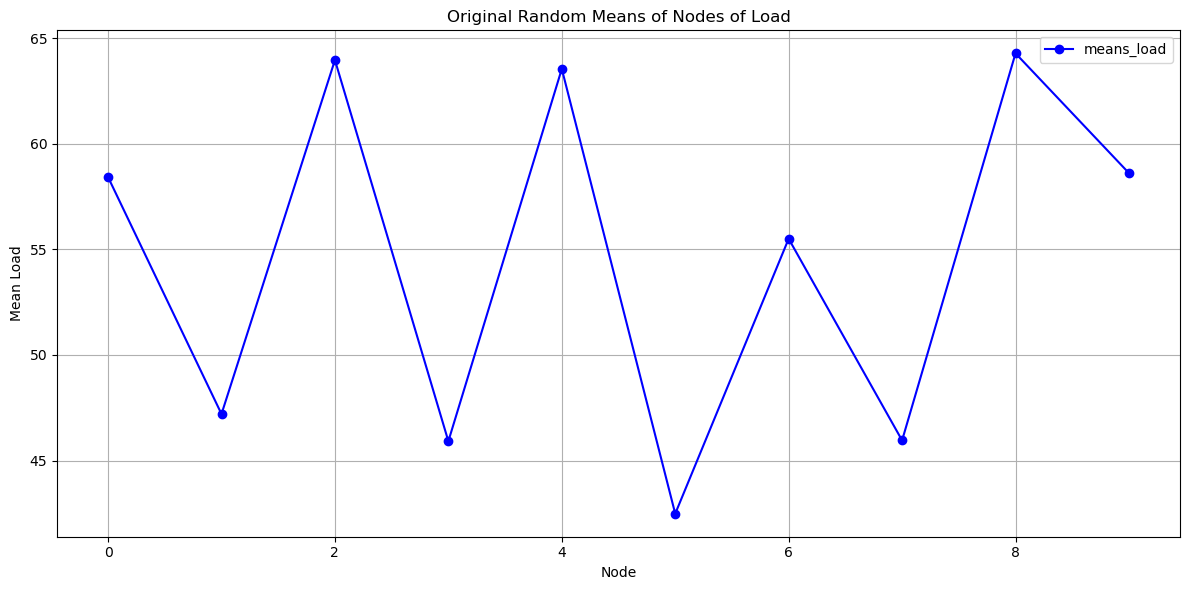

-----------------Train and Valid Data Info-----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
data_type: iid
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10])
train_x.shape: torch.Size([7980, 20, 10])
train_y.shape: torch.Size([7980, 10])
val_x.shape: torch.Size([2000, 20, 10])
val_y.shape: torch.Size([2000, 10])
---------- Train and Valid Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/15

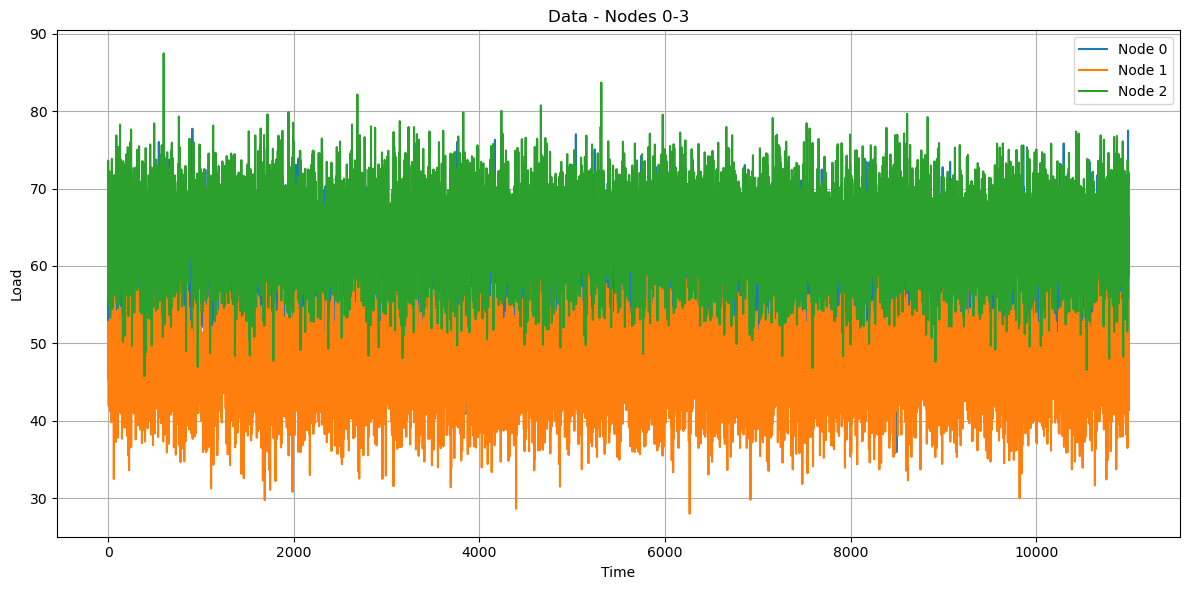

-----------------Train and Valid Data Info-----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
data_type: ar1
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10])
train_x.shape: torch.Size([7980, 20, 10])
train_y.shape: torch.Size([7980, 10])
val_x.shape: torch.Size([2000, 20, 10])
val_y.shape: torch.Size([2000, 10])
---------- Train and Valid Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/15

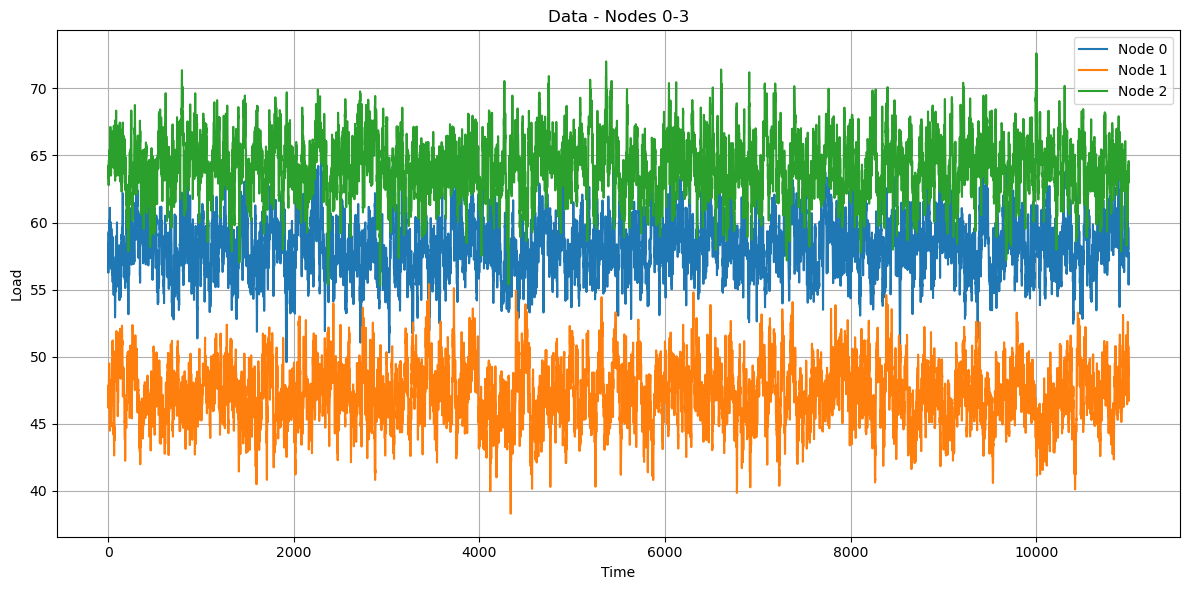

In [10]:
if __name__ == "__main__":
    # 加载 config.yaml 文件
    config = OmegaConf.load("config/config.yaml")

    # 打印完整的配置内容
    print(OmegaConf.to_yaml(config))

    # 确保数据目录存在
    if not os.path.exists('Data'):
        os.makedirs('Data')

    # 数据生成和管理
    data_generate = DataGenerate(config, if_save=True)
    iid_data_train_val_manage = TrainValidManage(config, 'iid')
    iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

    ar1_data_train_val_manage = TrainValidManage(config, 'ar1')
    ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')

    # 保存对象到文件
    with open('Data/iid_data_train_val_manage.pkl', 'wb') as f:
        pickle.dump(iid_data_train_val_manage, f)

    with open('Data/ar1_data_train_val_manage.pkl', 'wb') as f:
        pickle.dump(ar1_data_train_val_manage, f)